In [1]:
import pandas as pd
%reload_ext watermark
%matplotlib inline

import os
from scipy.stats import mannwhitneyu
from metapool.metapool import *
from metapool import (SAMPLE_DNA_CONC_KEY)
from metapool.mp_strings import (
    PM_SAMPLE_KEY, PM_LIB_WELL_KEY)
from metapool.util import warn_if_fp_exists
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2024-12-04T16:58:22.061150-08:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.12.0

metapool    : 0+untagged.221.gd899203
sample_sheet: 0.13.0
openpyxl    : 3.1.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Hostname: C02G21EEMD6Q

seaborn   : 0.13.2
numpy     : 2.0.0
pandas    : 2.2.2
json      : 2.0.9
matplotlib: 3.9.0
re        : 2.2.1



In [2]:
! conda list

# packages in environment at /Applications/miniconda3/envs/metapool:
#
# Name                    Version                   Build  Channel
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hdc70f33_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge
biom-format               2.1.16                   pypi_0  

# Knight Lab TellSeq pipeline notebook B

## Part 3 (of 5): Library concentration estimation

This portion of the notebook takes in fluorescent
 quantification values and produces visual outputs to interpret and check 
 values. 

As inputs, this workflow requires:
As inputs, it requires:
1. A tab-delimited `*_plate_df_A.txt` file containing the plate map info from the compression/barcoding step
2. MiniPico output (tab-delimited text format with columns 'Concentration' and 'Well')

The workflow:
1. reads in the specified input files
2. calculates estimated library concentration
3. visualizes concentration
4. produces a tab-delimited `*_plate_df_B.txt` file containing the updated plate map info

### Part 3 of 5, Step 1 of 5: Read in the 384-well plate data and the experiment info

In [3]:
## INPUT
full_plate_fp = './test_output/QC/Tellseq_plate_df_A.txt'

In [4]:
# if the full_plate_fp does not end with "plate_df_A.txt", throw an error
expected_suffix = f"plate_df_A.txt"
if not full_plate_fp.endswith(expected_suffix):
    raise ValueError(f"Expected file ending with '{expected_suffix}'")

In [5]:
if not os.path.isfile(full_plate_fp):
    print("Problem! %s is not a path to a valid file" % full_plate_fp)

In [6]:
plate_df = pd.read_csv(full_plate_fp, sep='\t')
plate_df.head()

,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,...,Library Well_row,Library Well_col,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set_id,barcode_id
0,0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,A,1,A1,A1,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col1to6,C501
1,192,01LJ01100.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,...,B,1,B1,A2,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col1to6,C509
2,12,01LJ01597.V8,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,C,1,C1,B1,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col1to6,C502
3,204,01LJ01315.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,...,D,1,D1,B2,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col1to6,C510
4,24,01LJ02862.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,E,1,E1,C1,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col1to6,C503


In [7]:
is_absquant(plate_df)

False

### Part 3 of 5, Step 2 of 5: read in MiniPico library concentration
Enter path to MiniPico file:

In [8]:
## INPUT
lib_concs_fp = './test_data/Quant/MiniPico/Tellseq_clean_lib_quant.txt'

In [9]:
# 'Well' differs from 'Library Well' because the former specifies the 
# gDNA source well while the latter specifies the well (destination well) that 
# will contain the sequencing library for the sample. These contain the same
# info when replicates are not used, but differ when replicates ARE used,
# so it is safer to use 'Library Well' in both cases.
# (Careful!  well_col is a global variable used throughout rest of notebook)
well_col = PM_LIB_WELL_KEY

In [10]:
lib_concs = read_pico_csv(lib_concs_fp, plate_reader='SpectraMax_i3x',
                          conc_col_name='MiniPico Library DNA Concentration')
lib_concs.rename(columns={'Well':well_col},inplace=True)
plate_df = pd.merge(plate_df, lib_concs, on=well_col)

plate_df.head()

,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,...,Library Well_col,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set_id,barcode_id,MiniPico Library DNA Concentration
0,0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,1,A1,A1,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col1to6,C501,0.612
1,192,01LJ01100.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,...,1,B1,A2,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col1to6,C509,0.623
2,12,01LJ01597.V8,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,1,C1,B1,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col1to6,C502,0.632
3,204,01LJ01315.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,...,1,D1,B2,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col1to6,C510,0.606
4,24,01LJ02862.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,1,E1,C1,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col1to6,C503,1.001


### Part 3 of 5, Step 3 of 5: calculate sample concentration from MiniPico

You will want to make sure that 'size' is correct for your average library size.

In [11]:
plate_df['MiniPico Library Concentration'] = \
    compute_pico_concentration(
        plate_df['MiniPico Library DNA Concentration'], size=500)
plate_df.head()

,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,...,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set_id,barcode_id,MiniPico Library DNA Concentration,MiniPico Library Concentration
0,0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,A1,A1,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col1to6,C501,0.612,1.854545
1,192,01LJ01100.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,...,B1,A2,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col1to6,C509,0.623,1.887879
2,12,01LJ01597.V8,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,C1,B1,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col1to6,C502,0.632,1.915152
3,204,01LJ01315.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,...,D1,B2,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col1to6,C510,0.606,1.836364
4,24,01LJ02862.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,E1,C1,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col1to6,C503,1.001,3.033333


### Part 3 of 5, Step 4 of 5: visualize MiniPico values

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

#### Library concentration by sample DNA concentration:

/Applications/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Applications/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Applications/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Applications/miniconda3/envs/metapool/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


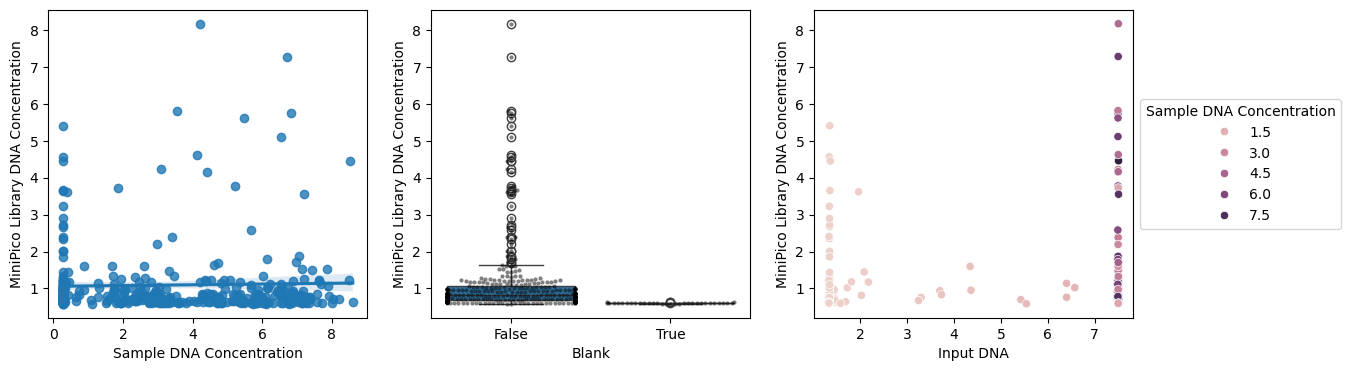

In [12]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
plate_df['Input DNA'] = plate_df['Sample DNA Concentration']*plate_df['Normalized DNA volume']/1000
sns.regplot(x="Sample DNA Concentration", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax1)
sns.boxplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2)
sns.swarmplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2,
              size=3,color='black',alpha=0.5)
sns.scatterplot( x="Input DNA",y="MiniPico Library DNA Concentration",hue='Sample DNA Concentration',data=plate_df ,ax = ax3)
ax3.legend(title='Sample DNA Concentration',loc='center left', bbox_to_anchor=(1, 0.5))

In [13]:
blanks_gdna_concs = plate_df.loc[plate_df['Blank']==True,'Sample DNA Concentration']
samples_gdna_concs = plate_df.loc[plate_df['Blank']==False,'Sample DNA Concentration']
mannwhitneyu(samples_gdna_concs, blanks_gdna_concs)

MannwhitneyuResult(statistic=np.float64(4537.5), pvalue=np.float64(0.06863164250220109))

In [14]:
blanks_lib_concs = plate_df.loc[plate_df['Blank']==True,'MiniPico Library Concentration']
samples_lib_concs = plate_df.loc[plate_df['Blank']==False,'MiniPico Library Concentration']
mannwhitneyu(samples_lib_concs, blanks_lib_concs)

MannwhitneyuResult(statistic=np.float64(10939.0), pvalue=np.float64(1.0724957587836943e-18))

#### Library concentration heatmap, whole plate

In [15]:
# get concentration and pooling values for plotting
concs = make_2D_array(plate_df, data_col="MiniPico Library Concentration", well_col=well_col).astype(float)
dna = make_2D_array(plate_df, data_col=SAMPLE_DNA_CONC_KEY, well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=well_col)

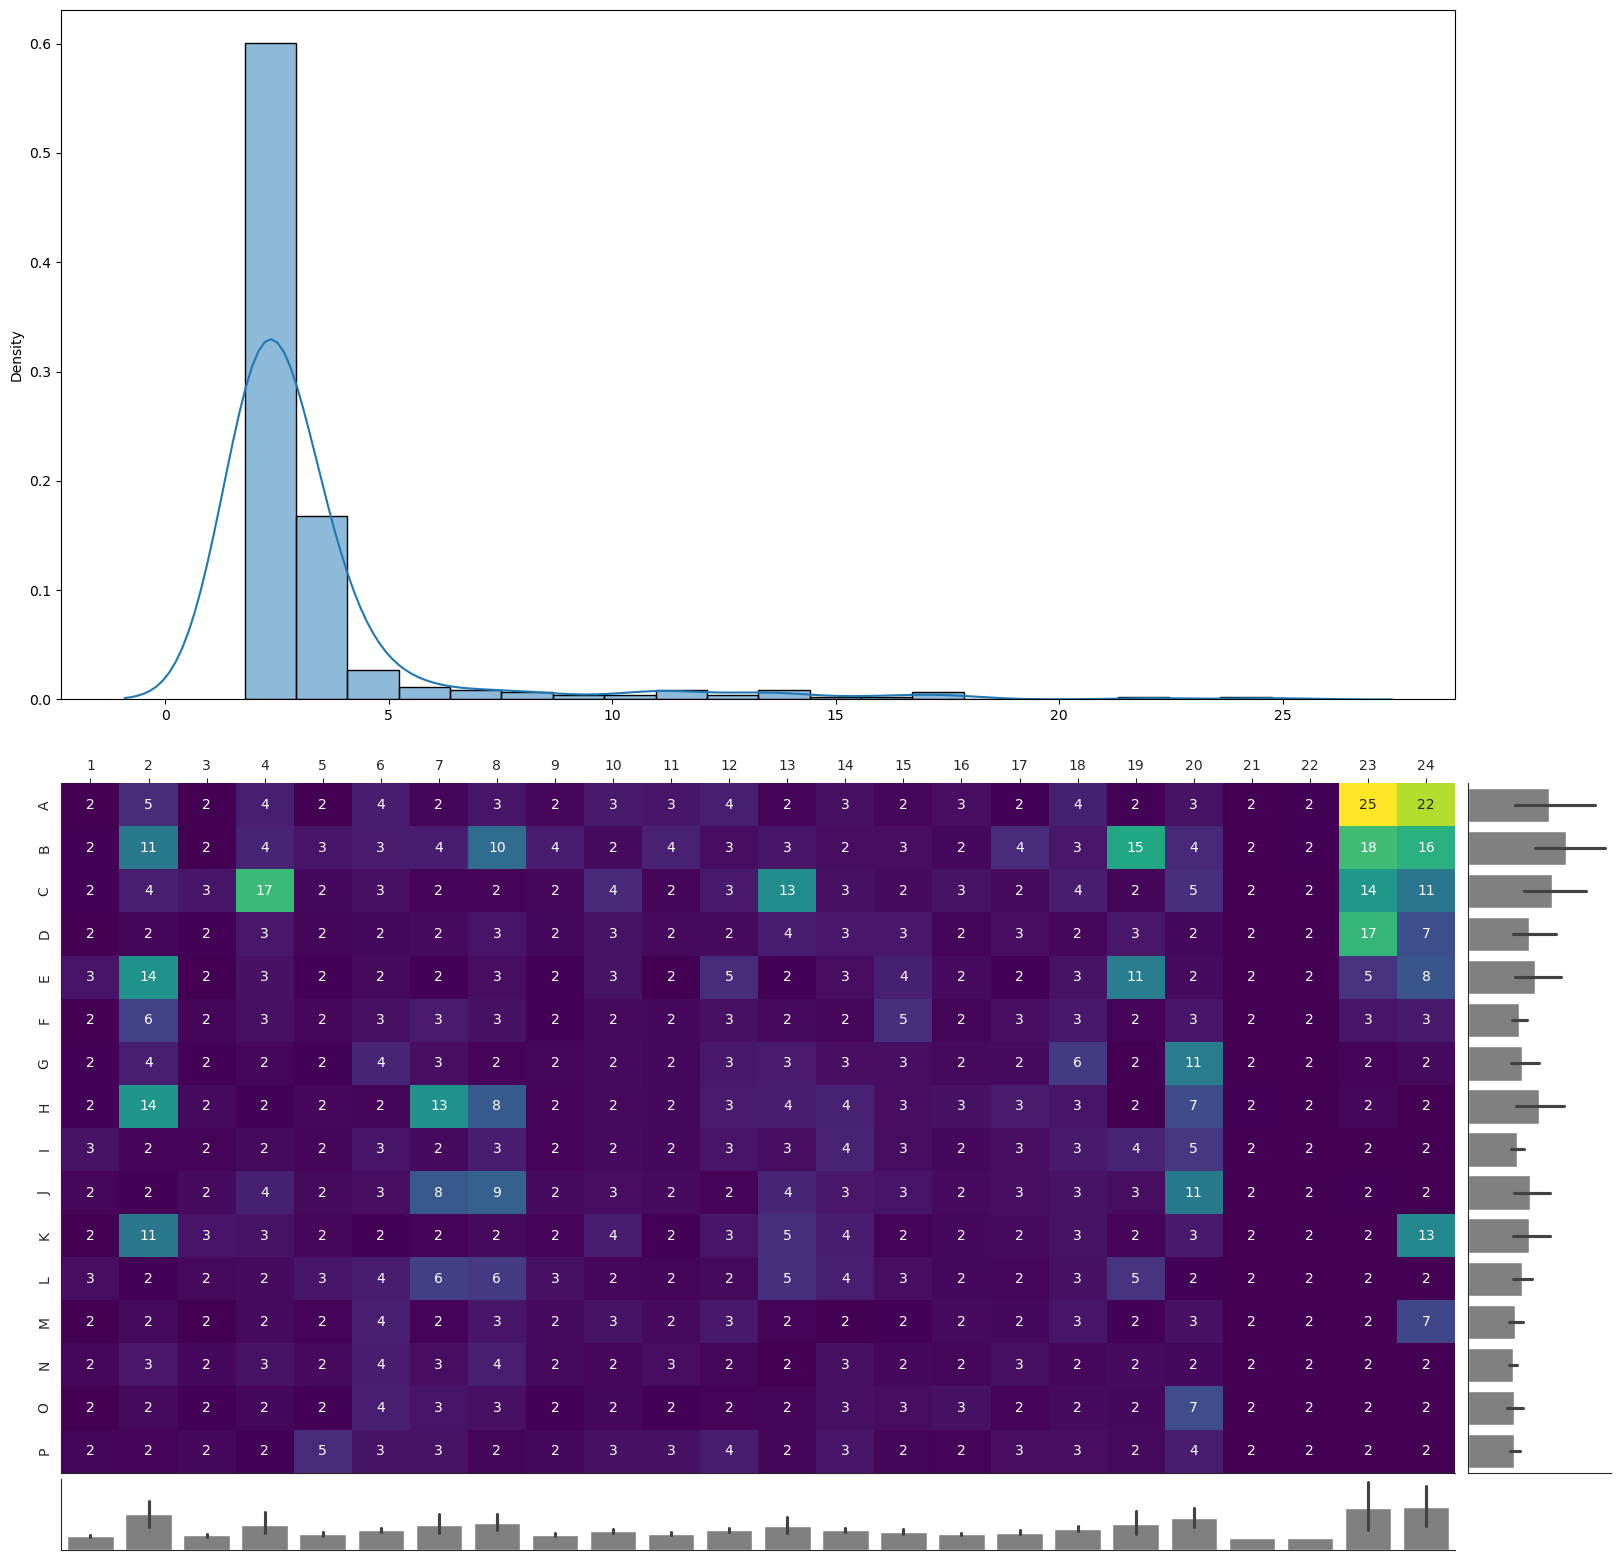

In [16]:
plot_plate_vals(concs, color_map='viridis')

#### Plate maps for individual constituent plates

In [17]:
# CONSTANTS: Users, DO NOT CHANGE THESE
# values without consulting with tech team

# Mask arrays for even and odd rows and columns
EVEN_ROWS = [x for x in range(16) if x % 2 == 0]
ODD_ROWS = [x for x in range(16) if x % 2 == 1]
EVEN_COLS = [x for x in range(24) if x % 2 == 0]
ODD_COLS = [x for x in range(24) if x % 2 == 1]

##### Library concentration heatmap, Plate 1

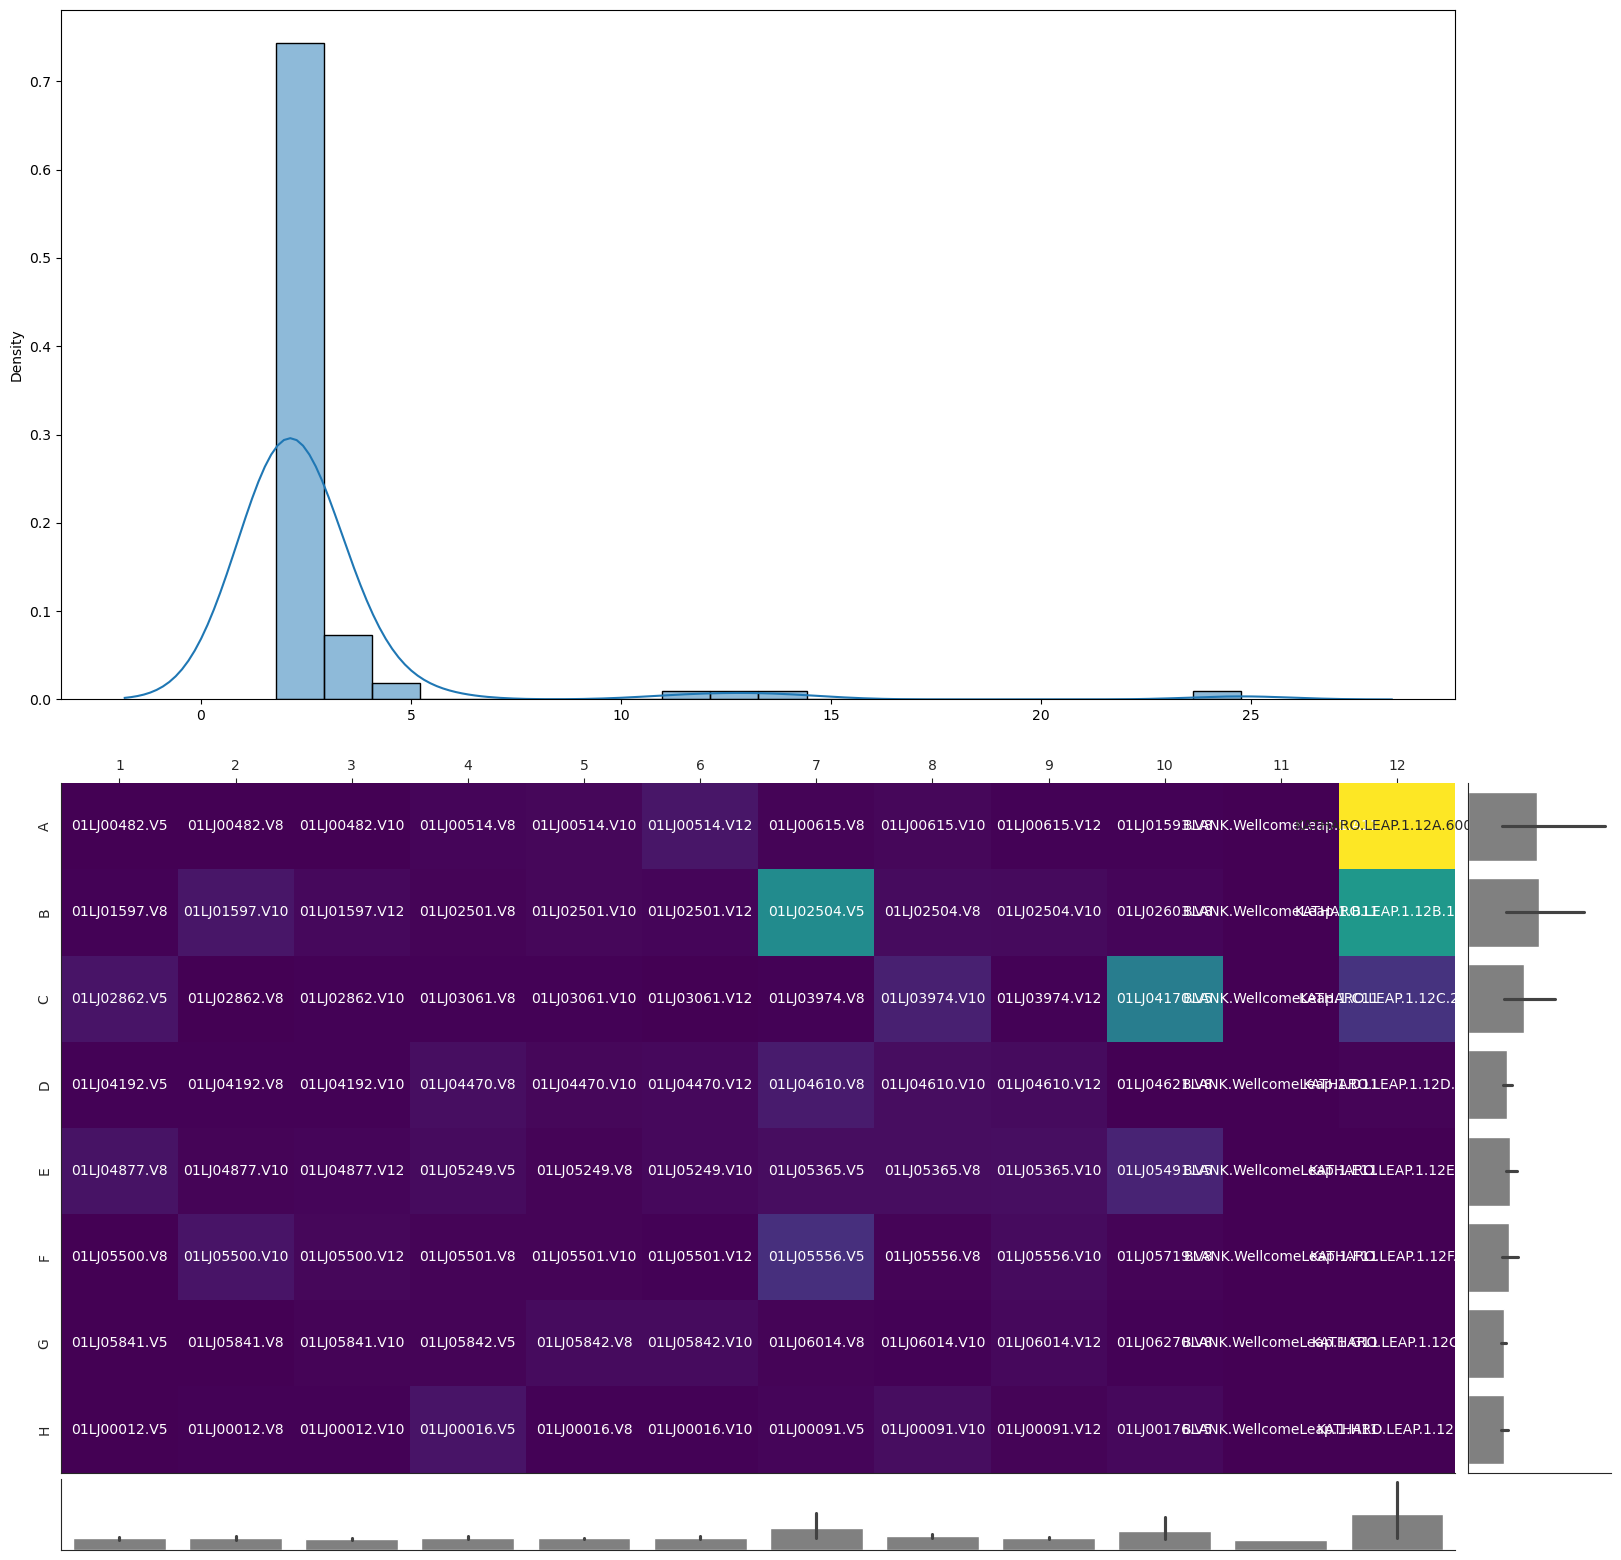

In [18]:
plot_plate_vals(concs[np.ix_(EVEN_ROWS,EVEN_COLS)],
                    annot_str= names[np.ix_(EVEN_ROWS,EVEN_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 2

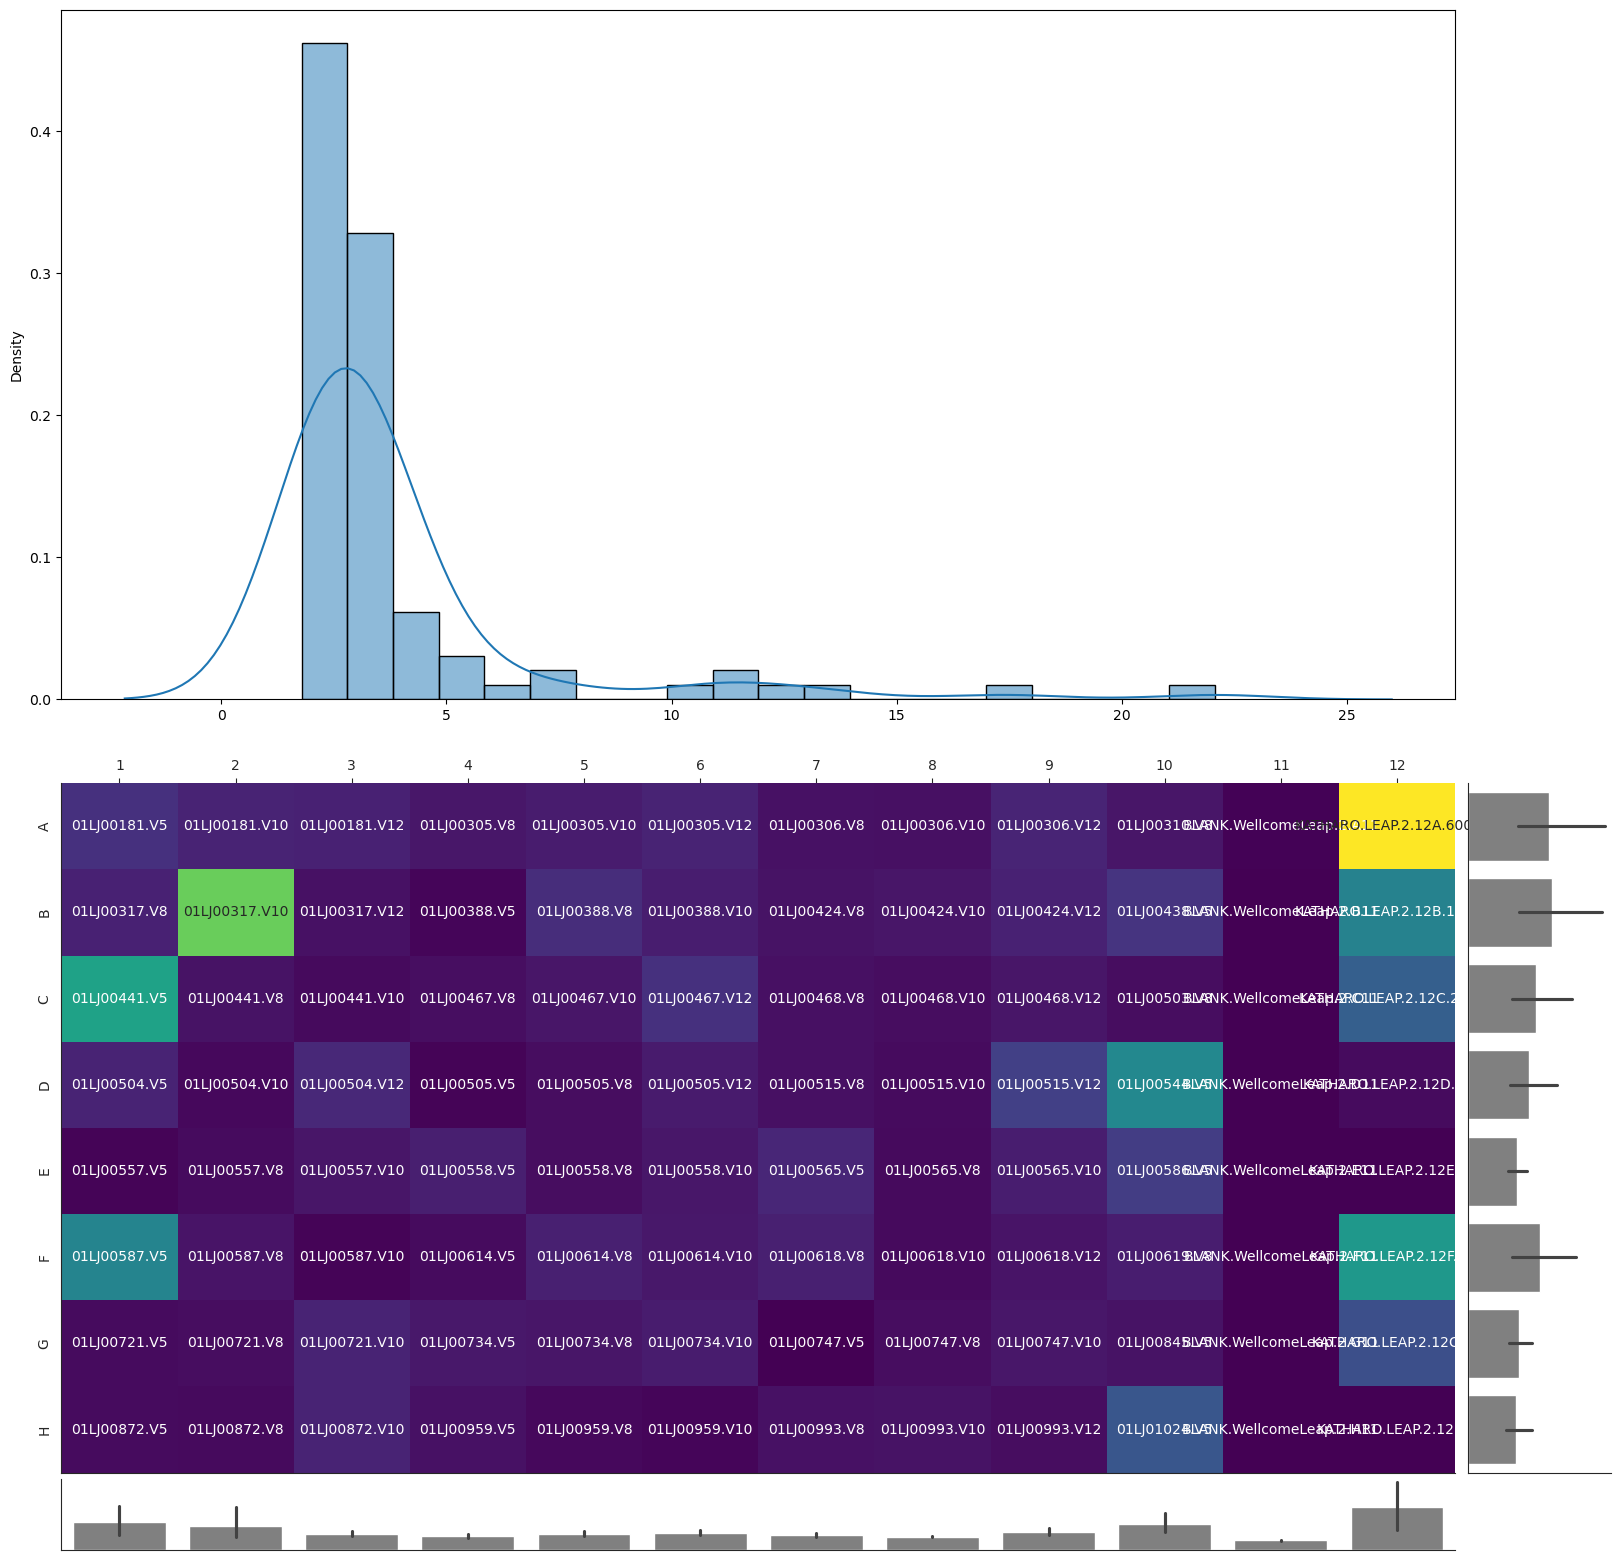

In [19]:
plot_plate_vals(concs[np.ix_(EVEN_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(EVEN_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 3

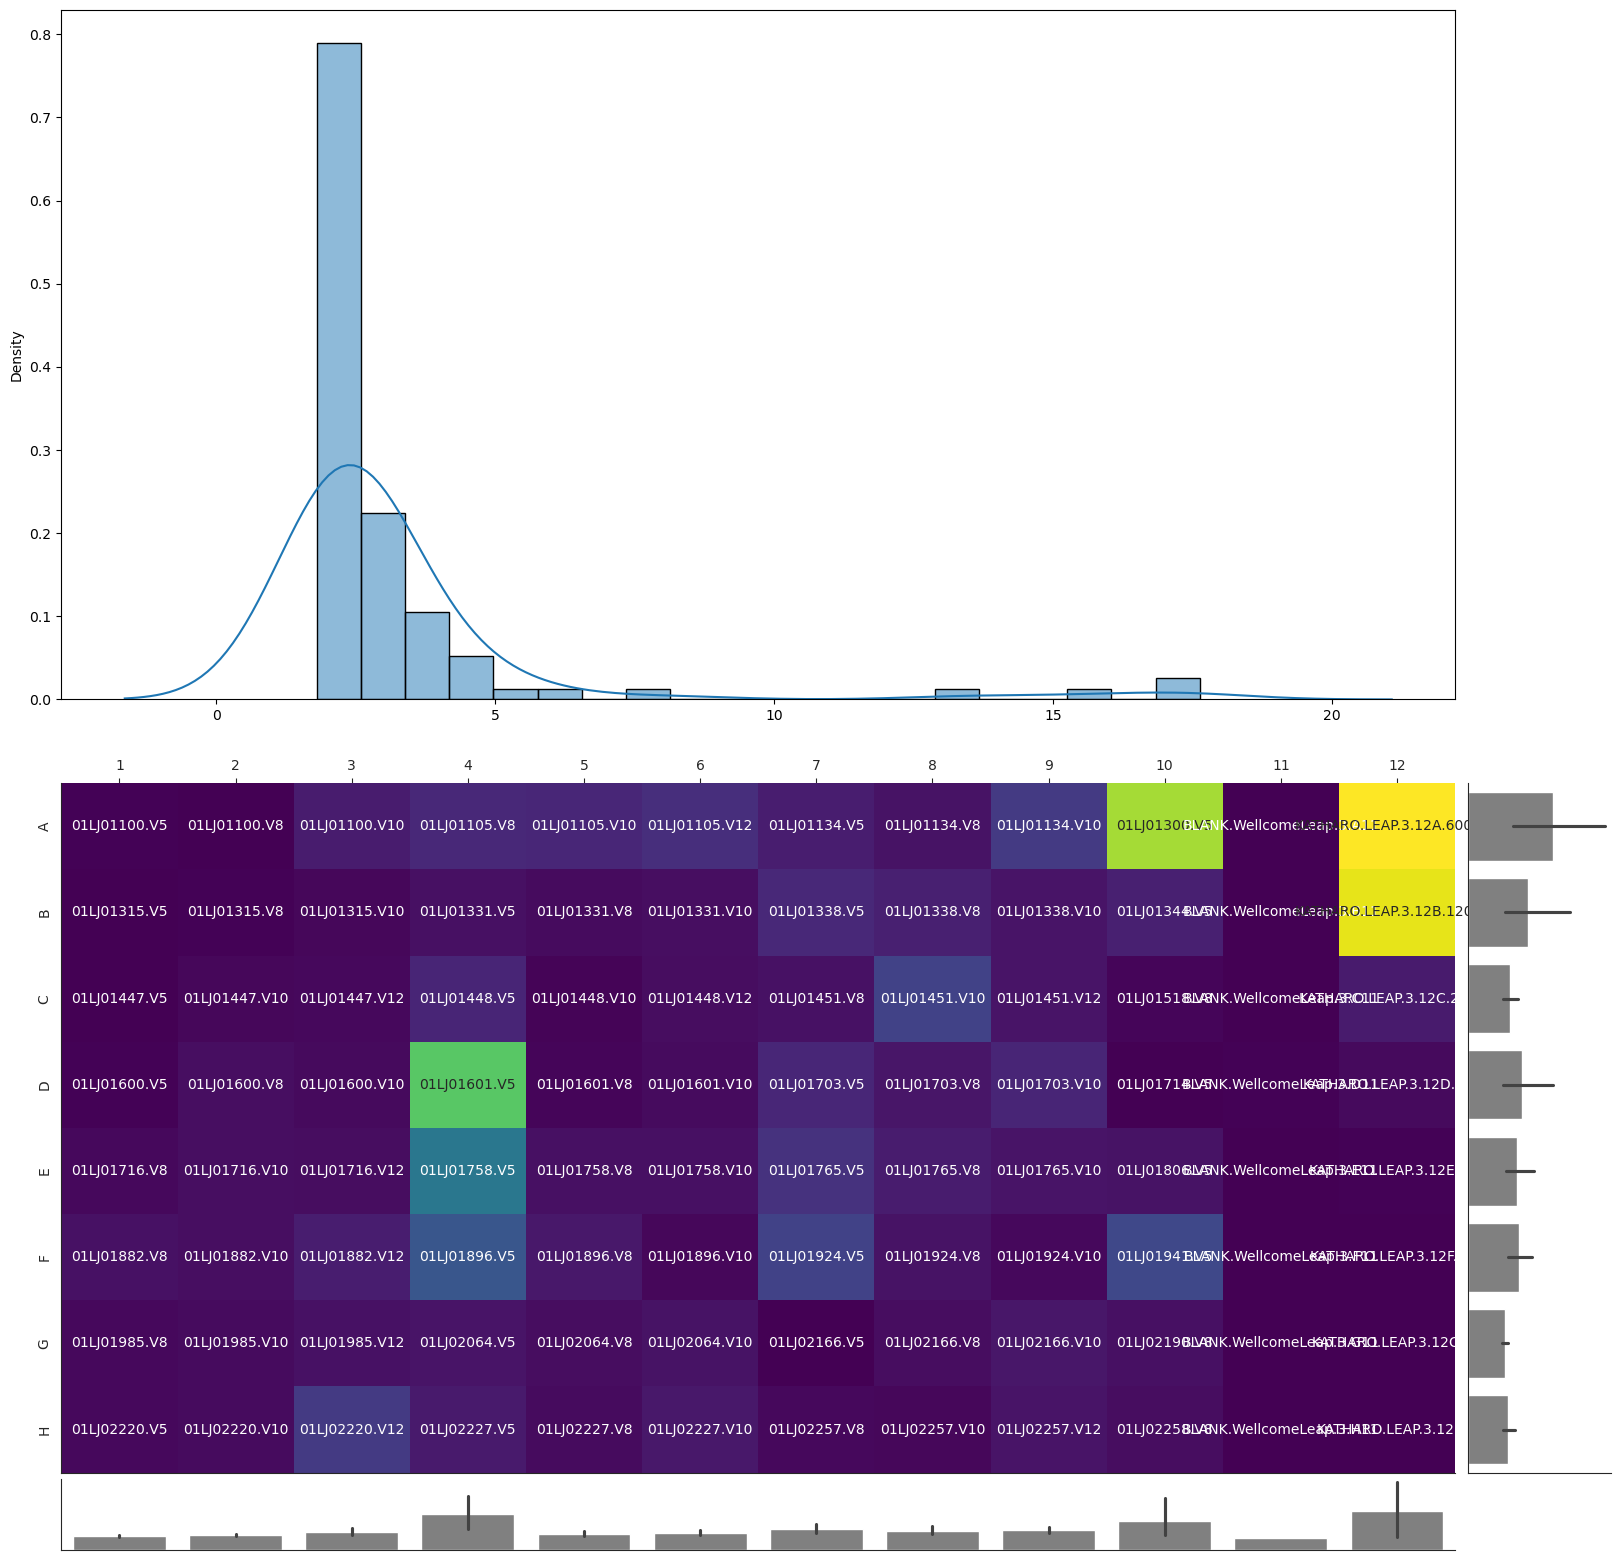

In [20]:
plot_plate_vals(concs[np.ix_(ODD_ROWS,EVEN_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,EVEN_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 4

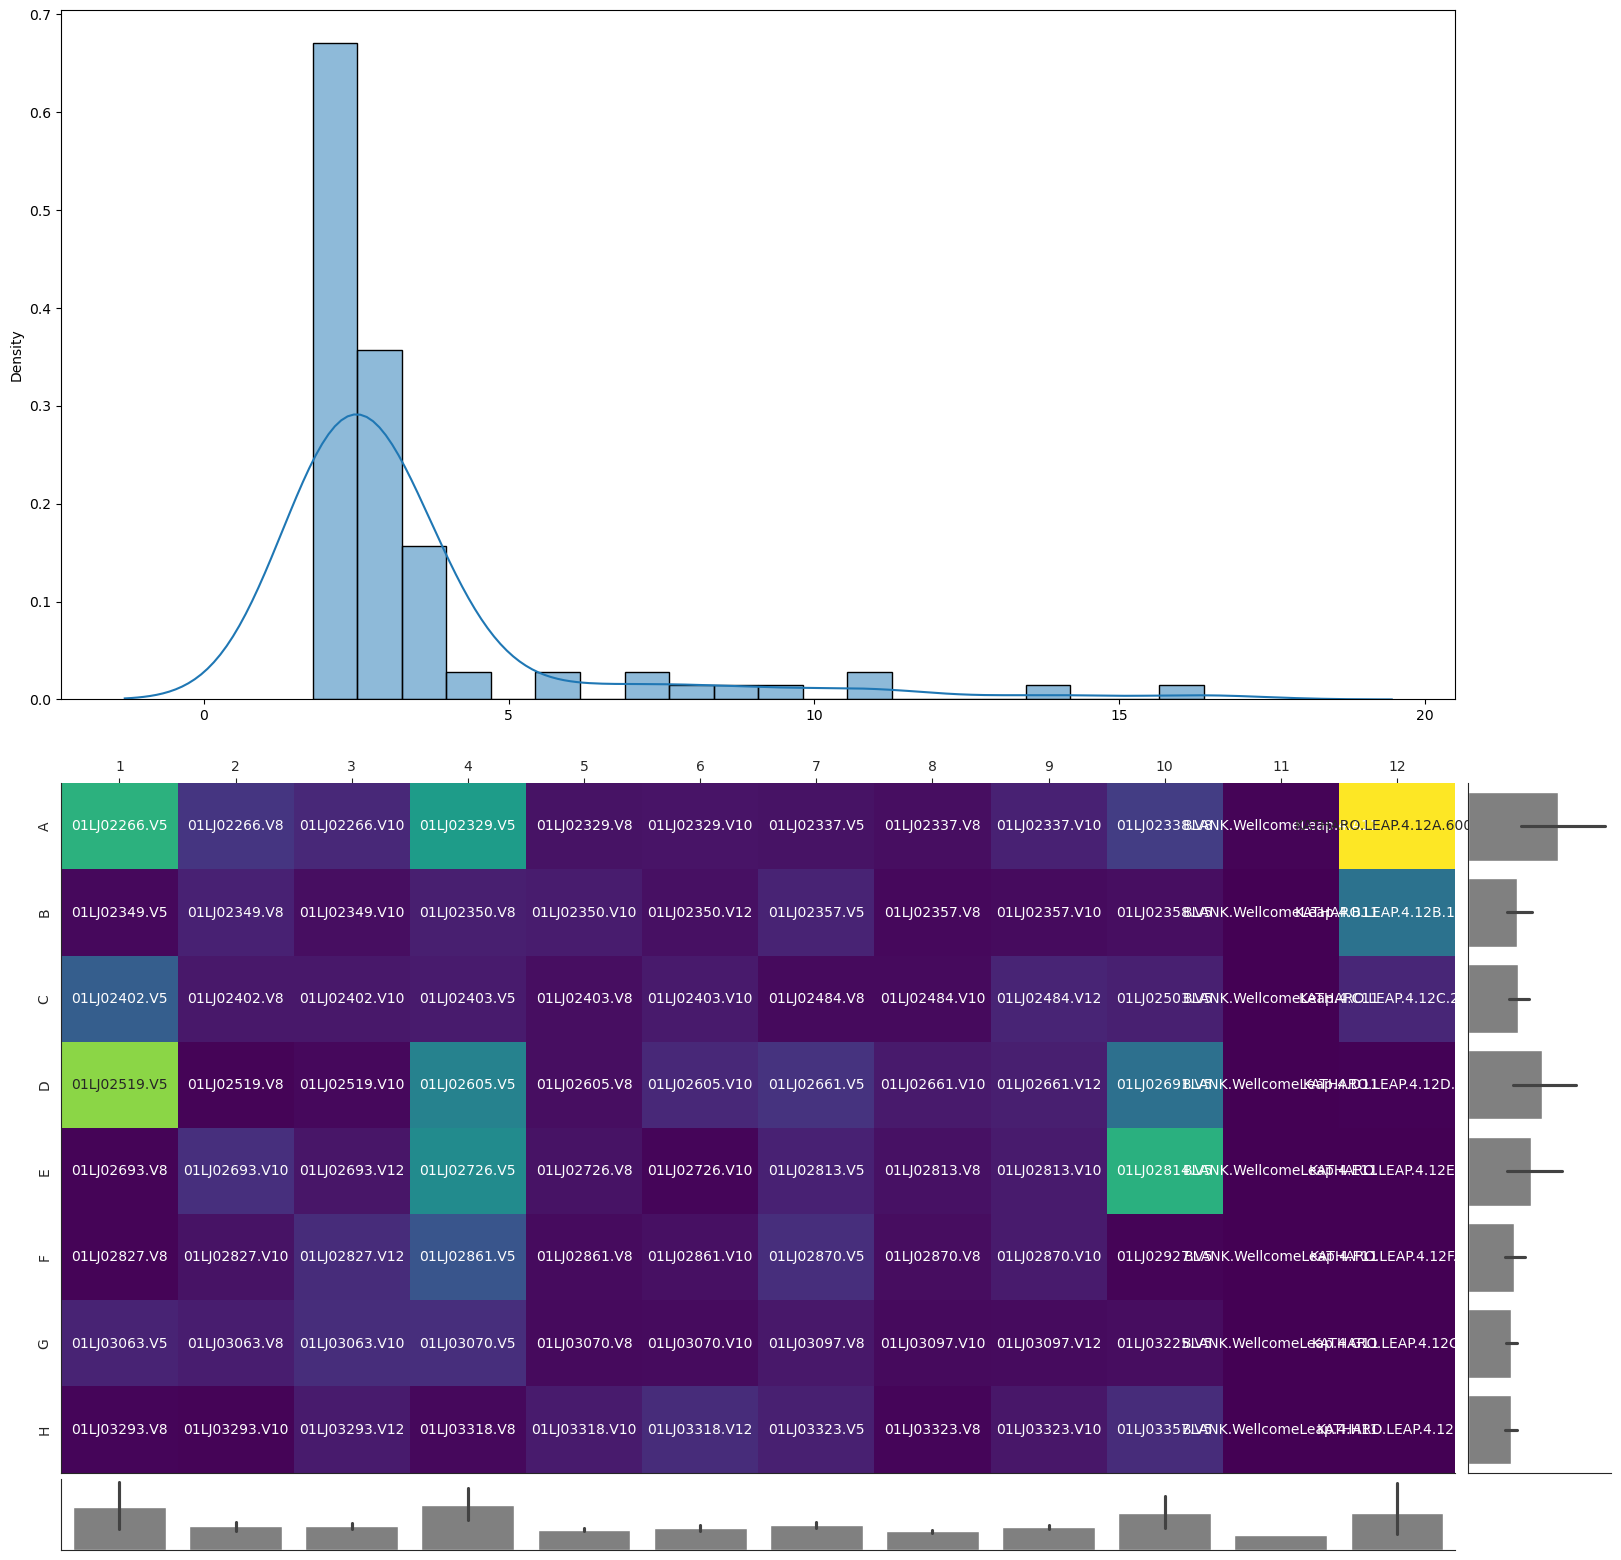

In [21]:
plot_plate_vals(concs[np.ix_(ODD_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

### Part 3 of 5, Step 5 of 5: Write plate info to file

We want to keep all that useful information together in one place so that
it can be easily parsed later. Enter the base (without extension) of the output file name; the code will provide the extension.

In [24]:
## INPUT
plate_df_fbase = './test_output/QC/Tellseq'

Add final column to plate df, then save to a file.

In [25]:
plate_df['sample sheet Sample_ID'] = \
    plate_df[PM_SAMPLE_KEY].map(bcl_scrub_name)
plate_df.head()

,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,...,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set_id,barcode_id,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,sample sheet Sample_ID
0,0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col1to6,C501,0.612,1.854545,7.495680,01LJ00482_V5
1,192,01LJ01100.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,...,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col1to6,C509,0.623,1.887879,7.502390,01LJ01100_V5
2,12,01LJ01597.V8,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col1to6,C502,0.632,1.915152,7.502735,01LJ01597_V8
3,204,01LJ01315.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,Wellcome_Leap_Plate_3,...,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col1to6,C510,0.606,1.836364,7.494064,01LJ01315_V5
4,24,01LJ02862.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,Wellcome_Leap_Plate_1,...,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col1to6,C503,1.001,3.033333,7.503163,01LJ02862_V5


In [26]:
plate_df_fp = f"{plate_df_fbase}_plate_df_B.txt"
warn_if_fp_exists(plate_df_fp)

In [27]:
plate_df.to_csv(plate_df_fp, sep='\t')